<a href="https://colab.research.google.com/github/iremond/Progetto_HLT/blob/main/Distilbert_ita_best_model_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/HLT

/content/drive/MyDrive/HLT


# Data loading

In [5]:
df_dev = load_dataset("csv", data_files="dataset/subtaskA_clean_dev_cased.csv")
# df_test = load_dataset("csv", data_files="dataset/subtaskA_clean_test_cased.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

# Data partioning

In [6]:
train_test = df_dev['train'].train_test_split(test_size=0.09, seed=0)
train_test

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 1674
    })
    test: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 166
    })
})

In [7]:
df_train = train_test["train"]
df_test = train_test["test"]

In [8]:
df_train = df_train.rename_column("comment_text", "text")
df_train = df_train.rename_column("conspiratorial", "labels")
df_test = df_test.rename_column("comment_text", "text")
df_test = df_test.rename_column("conspiratorial", "labels")

In [9]:
df_test

Dataset({
    features: ['text', 'labels'],
    num_rows: 166
})

In [10]:
df_train

Dataset({
    features: ['text', 'labels'],
    num_rows: 1674
})

# Model loading

In [11]:
nome = 'distilbert-base-it-cased'
model_name = 'Geotrend/distilbert-base-it-cased'

In [12]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data preprocessing

In [13]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [14]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_test = df_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/1674 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

# Training

In [15]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [16]:
def hyperparameter_search(model_name=model_name, optim='adagrad', learning_rate=0.00005, dropout=0.1):
# inserire i parametri di default del modello
    training_args = TrainingArguments(
            output_dir=f"{nome}-finetuned",
            evaluation_strategy = "no",
            save_strategy = "epoch",
            logging_strategy="epoch",
            num_train_epochs=9,
            # load_best_model_at_end=True, # the best model might not be the one at the end of training => we load the best saved model
            # metric_for_best_model='eval_f1',
            seed=42,
            optim=optim,
            learning_rate=learning_rate # default 0.00005
            #per_device_train_batch_size # default 8
            #per_device_eval_batch_size # default 8
            #weight_decay=0.0001 # default 0 # disastro
            )
    config = AutoConfig.from_pretrained(model_name)
    config.dropout = dropout
    model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)
    return config, training_args, model

In [17]:
dropout = 0.05
learning_rate = 0.00007

config, training_args, model = hyperparameter_search(dropout=dropout, learning_rate=learning_rate)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    # eval_dataset=tokenized_val,
    compute_metrics=compute_metrics)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Geotrend/distilbert-base-it-cased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(25496, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.05, inplace=False)

In [19]:
config

DistilBertConfig {
  "_name_or_path": "Geotrend/distilbert-base-it-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.05,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.33.0",
  "vocab_size": 25496
}

In [20]:
%%time
trainer.train()

Step,Training Loss
210,0.558100
420,0.446700
630,0.388400
840,0.342700
1050,0.317800
1260,0.293000
1470,0.275300
1680,0.275100
1890,0.268600


CPU times: user 10min 58s, sys: 6.56 s, total: 11min 5s
Wall time: 12min 29s


TrainOutput(global_step=1890, training_loss=0.3517503587026445, metrics={'train_runtime': 748.7126, 'train_samples_per_second': 20.123, 'train_steps_per_second': 2.524, 'total_flos': 1995753828151296.0, 'train_loss': 0.3517503587026445, 'epoch': 9.0})

# Evaluation

In [21]:
log_history = trainer.state.log_history

In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
#df

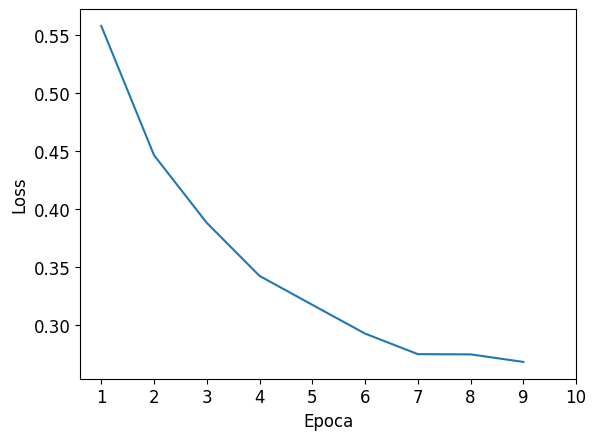

In [24]:
# loss lineplot
plt.rcParams.update({'font.size': 12})
sns.lineplot(data=df, x="Epoch", y="Loss")#, hue="Dataset")
plt.xticks(range(1, 11))
plt.xlabel('Epoca')
plt.savefig(f'loss_curves_{nome}_eval_loss.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
output_predictions = trainer.predict(tokenized_test)

In [27]:
y_val = tokenized_test["labels"]
y_val_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.70      0.75        86
           1       0.71      0.81      0.76        80

    accuracy                           0.75       166
   macro avg       0.76      0.76      0.75       166
weighted avg       0.76      0.75      0.75       166



In [28]:
with open(f"class_report_{nome}_eval_f1.html", "w") as file:
    file.write(report)

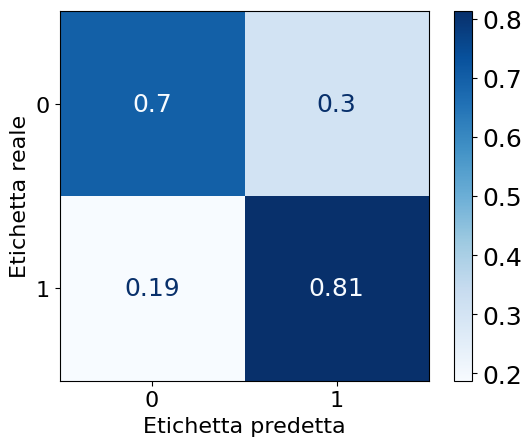

In [29]:
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig(f'conf_matrix_{nome}_eval_f1.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
def error_analyze(y_true, y_pred):
  df = df_test.to_pandas()
  df_errors = df.copy()
  errors = dict()

  for idx, value in enumerate(y_true):
    if value != y_pred[idx]:
      errors[idx] = (value, y_pred[idx])

  error_idx = list(errors.keys())
  df_errors = df.loc[error_idx].copy()
  for i, row in df_errors.iterrows():
    df_errors.loc[i, 'Pred'] = y_pred[i]
  df_errors['Pred'] = df_errors['Pred'].astype(int)
  df_errors.to_csv('errors_A.csv', index=False)

  return df_errors

In [34]:
errors = error_analyze(y_val, y_val_pred)

print(errors)

                                                  text  labels  Pred
10   Ma voi avete trovato un partito che sia contro...       0     1
14   Le navi mercantili in attesa davanti al porto ...       0     1
15   Ecco come mettono in orbita i satellitti.  (or...       1     0
21   Morti misteriose di scienziati: la lista si al...       1     0
24   Se per fare il tuo lavoro è obbligatoria la va...       1     0
25   breve ed interessante riflessione sulle condiz...       0     1
26   Breve e bellissimo intervento su dove la scuol...       0     1
28   Ma cosa dite che è rimasto il 9% non è vero, s...       0     1
36   In realtà in quasi tutti gli stati europei alc...       0     1
39   La cosa strana e' che durante il gioco il tast...       0     1
42   AH,, dimenticabo nessuno puo- andare oltre l-0...       1     0
48   Il paese più vaccinato d'europa con 66 milioni...       0     1
50   La verità è lì, davanti a noi, riuscite a vederla       1     0
51   Di mostruosa,c'è solo la pale